In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from biopsykit.classification.model_selection import SklearnPipelinePermuter

from src.pepbench.io import compute_abs_error

from src.pepbench.plotting.results import boxplot_algorithm_performance, _plot_helper_algorithm_performance

from fau_colors import cmaps, register_fausans_font

In [2]:
#register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

In [3]:
data_path = Path("../../../results/data/b-point")
model_path = Path("../../../results/models/b-point")
output_image_path = Path("Images/Paper")

### Load the pipeline permuter of the best performing ML-Estimators
- ('StandardScaler', 'SelectFromModel', 'SVR') Data: Include RR-Interval
- ('StandardScaler', 'SelectKBest', 'RandomForestRegressor') Data: Without RR-Interval
- ('StandardScaler', 'SelectFromModel', 'SVR') Data: Without RR-Interval
- ('StandardScaler', 'SelectFromModel', 'SVR') Data: Without RR-Interval

In [42]:
best_ml_estimators = {
    "SScaler-SFM-SVR-RR": ('StandardScaler', 'SelectFromModel', 'SVR'),
    "SScaler-SKB-RFR": ('StandardScaler', 'SelectKBest', 'RandomForestRegressor'),
    "SScaler-SFM-RFR": ('StandardScaler', 'SelectFromModel', 'RandomForestRegressor'),
    "SScaler-SFM-SVR": ('StandardScaler', 'SelectFromModel', 'SVR'),
}

In [32]:
permuter_without_rr = SklearnPipelinePermuter.from_pickle(model_path.joinpath("without-rr-interval/b_point_regression_hpc_0_baseline_result.pkl"))
test = permuter_without_rr.metric_summary().loc[('StandardScaler', 'SelectFromModel', 'DecisionTreeRegressor')][['test_indices', 'predicted_labels']].to_frame().T

In [44]:
permuter_without_rr.metric_summary()

conf_matrix  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                        
StandardScaler  SelectFromModel     DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
                SelectKBest         DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
                SelectKBest         DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   

                                                          conf_matrix_folds  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                              
StandardScaler  SelectFromModel     DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
                SelectKBest         DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
                SelectKBest         DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   

                                                                                                 true_labels  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                                                               
StandardScaler  SelectFromModel     DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    SVR                    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    KNeighborsRegressor    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                SelectKBest         DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    SVR                    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    KNeighborsRegressor    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 

In [40]:
test_processed = pd.DataFrame()
test_processed[f'test_indices'] = test['test_indices'].values[0]
test_processed['predicted_labels'] = test['predicted_labels'].values[0]
# Generate dataframe with test_indices and predicted_labels for each of the ML-estimators that should be compared by looping over the best_ml_estimators dict
# merge with generated dataframe with training data for each iteration in the loop (algorithm combination)
# --> ML-Estimator results are in the same table as the results of the classic algos

In [41]:
test_processed

,test_indices,predicted_labels
0,2257,368.0
1,2258,342.0
2,2259,376.0
3,2260,352.5
4,2261,336.0
...,...,...
10392,10137,222.0
10393,10138,222.0
10394,10139,216.0
10395,10140,226.0


In [5]:
permuter_with_rr = SklearnPipelinePermuter.from_pickle(model_path.joinpath("rr-interval/b_point_regression_hpc_0_baseline_result_rr_interval.pkl"))

In [7]:
permuter_with_rr.metric_summary().loc[best_ml_estimators['SScaler-SFM-SVR-RR']]['predicted_labels']

array([375.81995928, 350.18902946, 374.04646813, ..., 217.55289636,
       228.28364717, 222.48543424], shape=(10305,))

### Load the data used to train the ML-estimators

In [15]:
data_without_rr = pd.read_csv(data_path.joinpath('without-rr-interval/train_data_b_point.csv'), index_col=[0,1,2,3,4,5])
data_without_rr

,,,,,,arbol2017-isoelectric-crossings,arbol2017-second-derivative,arbol2017-third-derivative,debski1993-second-derivative,drost2022,forounzafar2018,lozano2007-linear-regression,lozano2007-quadratic-regression,sherwood1990,stern1985
,participant,condition,phase,heartbeat_id_reference,b_point_sample_reference,,,,,,,,,,
0,GDN0005,Dummy,HoldingBreath,0,388.0,438.0,398.0,394.0,452.0,400.0,550.0,412.0,384.0,442.0,388.0
1,GDN0005,Dummy,HoldingBreath,1,404.0,340.0,350.0,244.0,388.0,420.0,402.0,404.0,384.0,330.0,402.0
2,GDN0005,Dummy,HoldingBreath,3,376.0,382.0,296.0,386.0,366.0,386.0,388.0,366.0,348.0,382.0,374.0
3,GDN0005,Dummy,HoldingBreath,4,390.0,394.0,344.0,396.0,376.0,396.0,398.0,372.0,348.0,394.0,388.0
4,GDN0005,Dummy,HoldingBreath,5,386.0,398.0,312.0,388.0,418.0,392.0,390.0,378.0,354.0,400.0,384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11606,VP_032,tsst,Talk,39,310.0,335.0,276.0,324.0,300.0,318.0,306.0,305.0,294.0,337.0,306.0
11607,VP_032,tsst,Talk,40,322.0,331.0,298.0,330.0,311.0,322.0,311.0,321.0,303.0,329.0,287.0
11608,VP_032,tsst,Talk,41,340.0,317.0,300.0,348.0,330.0,343.0,309.0,332.0,322.0,311.0,287.0


In [8]:
# Calculate the error per sample based on the training data and the test_indices from the pipeline permuter

In [10]:
ml_estimators_absolute_error = pd.DataFrame()
for key, value in best_ml_estimators.items():
    ml_estimators_absolute_error[key] = compute_abs_error(permuter_with_rr.metric_summary().loc[best_ml_estimators[key]]['predicted_labels'], permuter_with_rr.metric_summary().loc[best_ml_estimators[key]]['true_labels'])

In [11]:
ml_estimators_absolute_error

,SScaler-SFM-SVR-RR,SScaler-SKB-RFR,SScaler-SFM-RFR,SScaler-SFM-SVR
0,5.819959,5.676699,8.359402,5.819959
1,4.189029,4.234368,3.830549,4.189029
2,0.046468,0.305359,1.297863,0.046468
3,36.786989,31.399556,32.143760,36.786989
4,5.281993,5.500370,5.050857,5.281993
...,...,...,...,...
10300,0.906151,0.028585,0.278011,0.906151
10301,2.266656,2.224020,3.259611,2.266656
10302,3.447104,1.862277,2.139242,3.447104
10303,0.716353,0.165415,0.832624,0.716353


In [14]:
# adjust plotting functions from results.py to your needs
# - Load data used for training
# - Select the columns of the algorithms that should be compared
# - compute the absolute error
# - plot the data

Text(0.5, 1.0, 'ML-based B-Point Detection')

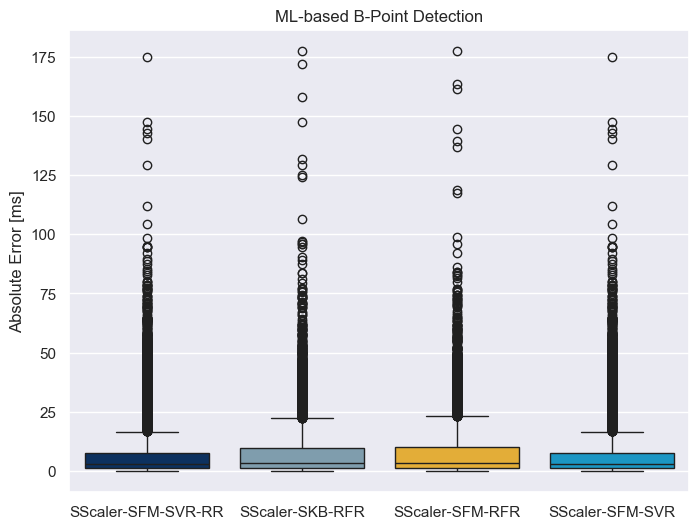

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=ml_estimators_absolute_error)
ax.set_ylabel('Absolute Error [ms]')
ax.set_title('ML-based B-Point Detection')